First read in the results from Runtime.hs

Each example is delimited with `__NEW_EXAMPLE__` 

In [9]:
from pathlib import Path
from matplotlib import pyplot as plt
import re
import pandas as pd
import numpy as np
import matplotlib
out_dir = Path("graphs")
out_dir.mkdir(exist_ok=True)



In [13]:
def read_result_file(fp):
    raw_results = fp.read_text()
    raw_results = raw_results.split("__START__")[-1].split("__END__")[0]
    raw_results = raw_results.split("__NEW_EXAMPLE__")[1:]
    
    
    # expected_num_examples = len(progs)
    print(f"{len(raw_results)} examples found")

    return raw_results

from collections import defaultdict

progs= {}
for f in list(Path("examples").glob("*")):
    if f.read_text() in progs:
        print(f"Found {f.stem} in {progs[f.read_text()]}")
        continue
    progs[f.read_text()] = f.stem
for i in range(1,51):
    if f"example{i}" not in progs.values():
        print(f"Missing {i}")
all_results = []
for fp in Path("results").glob("*"):
    if not fp.stem.startswith("results"):
        continue
    print(f"Reading: {fp}")
    all_results.extend(read_result_file(fp))


Reading: results\results1.txt
53 examples found
Reading: results\results2.txt
53 examples found
Reading: results\results3.txt
53 examples found
Reading: results\results4.txt
53 examples found
Reading: results\results5.txt
53 examples found


Each Example has:
* `SIZE_ORIG`-> The number of AST Nodes in the original program
* `IN`-> The original program
* `SYNTH`-> The synthesized program or "ERROR" if it failed
* `SIZE_SYNTH`-> Number of AST nodes in the final synthesized program.
* `TIME` -> The amount of time it took to run 

In [70]:
def parse_example_results(example_str):
    match = re.search(
        r"SIZE_ORIG:([0-9]+)\s+IN:([\s\S]+)SYNTH:([\s\S]+)SIZE_SYNTH:([\s\S]+)TIME:(.+)",
        flags=re.MULTILINE,
        string=example_str,
    )
    assert match is not None
    size_org = int(match.group(1).strip())
    prog = match.group(2).strip()

    has_hole = "{|" in prog or 'callcc' in prog
    synth = match.group(3).strip()
    failed = synth == "ERROR"
    if failed:
        size_synth = -1
    else:
        size_synth = int(match.group(4).strip())
    time, unit = match.group(5).strip().split()
    time = float(time)
    if unit == "us":
        time /= 1000
    if unit == "s":
        time *= 1000

    return {
            "has_hole": has_hole,
            "failed": failed,
            "size_orig": size_org,
            "program": prog,
            "synthesized": synth,
            "size_synth": size_synth,
            "time": [time],
        }
    

res_by_prog = {}
for r in map(parse_example_results,all_results):
    if r['program'] not in res_by_prog:
        res_by_prog[r["program"]] = r
    else:
        res_by_prog[r["program"]]["time"].extend(r["time"])

for k in res_by_prog:
    res_by_prog[k]["time"] = np.mean(res_by_prog[k]["time"])
df = pd.DataFrame(list(res_by_prog.values()))
df_passed = df[(df["has_hole"]) & (~df["failed"])]
print("Passing:")
print(f"\t{len(df_passed)}")
print(f"\tMean Time: {df_passed['time'].mean():0.2f} (+/-{df_passed['time'].std():0.2f})")
print(f"\tMean Size: {df_passed['size_synth'].mean():0.2f} (+/-{df_passed['size_synth'].std():0.2f})")
nodes_added = df_passed["size_synth"] - df_passed["size_orig"]
print(f"\tMean Nodes Added: {nodes_added.mean():0.2f} (+/-{nodes_added.std():0.2f})")
failed = df[df["failed"]]
print("Failed:")
print(f"\t{len(failed)}")
print(f"\tMean Time: {failed['time'].mean():0.2f} (+/-{failed['time'].std():0.2f})")



Passing:
	25
	Mean Time: 967.35 (+/-3040.54)
	Mean Size: 8.24 (+/-4.94)
	Mean Nodes Added: 6.64 (+/-3.96)
Failed:
	0
	Mean Time: nan (+/-nan)


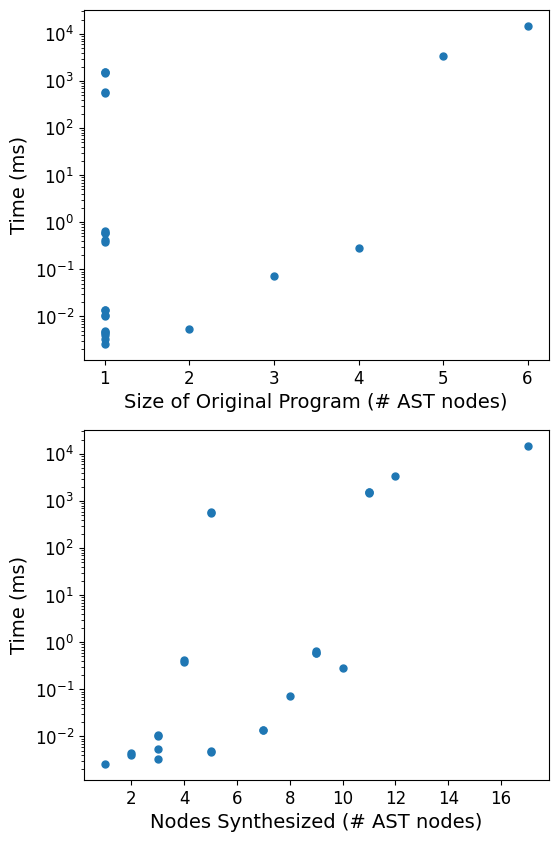

In [71]:
font = {'size': 12}
title_font_size = 14
matplotlib.rc('font', **font)
fig,ax = plt.subplots(2,1,figsize=(6, 10))
ax[0].plot(df_passed["size_orig"], df_passed["time"], "o",markersize=5)
ax[0].set_xlabel("Size of Original Program (# AST nodes)",fontsize=title_font_size)
ax[0].set_ylabel("Time (ms)",fontsize=title_font_size)
ax[0].set_yscale("log")


# fig.savefig(str(out_dir / "node_basic.png"))

# fig,ax = plt.subplots(1,1,figsize=(10, 8))
ax[1].plot(df_passed["size_synth"]-df_passed['size_orig'], df_passed["time"], "o",markersize=5)
ax[1].set_xlabel("Nodes Synthesized (# AST nodes)",fontsize=title_font_size)
ax[1].set_ylabel("Time (ms)",fontsize=title_font_size)
ax[1].set_yscale("log")
fig.savefig(str(out_dir / "basic_results.png"))

In [72]:
res_by_prog[k]["time"]

0.00398

In [73]:
failed

,has_hole,failed,size_orig,program,synthesized,size_synth,time


In [74]:
progs["(((1 + 2) - 4) * (0 - 1))"]

KeyError: '(((1 + 2) - 4) * (0 - 1))'

Reading: results\challenge1.txt
15 examples found
Reading: results\challenge2.txt
15 examples found
Reading: results\challenge3.txt
15 examples found
Reading: results\challenge4.txt
15 examples found
Reading: results\challenge5.txt
15 examples found


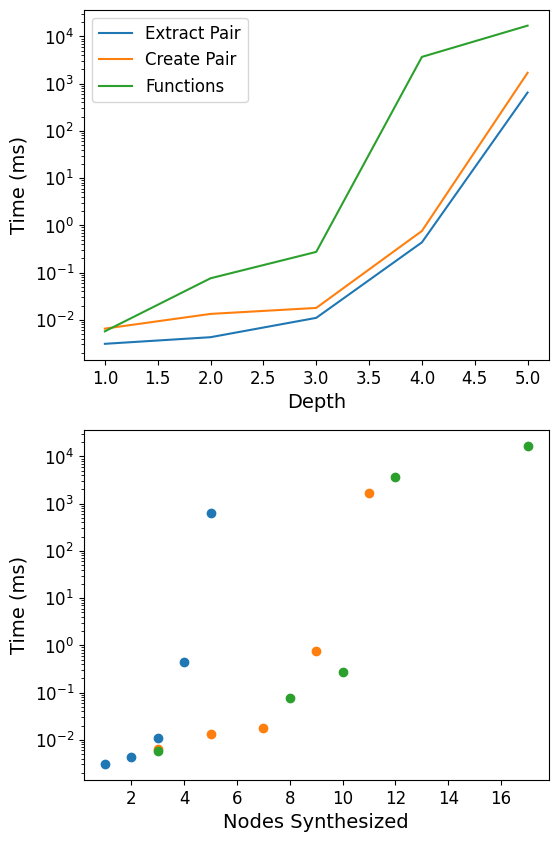

In [75]:
prog_to_group = defaultdict(list)
for f in list(Path("challenge_examples").glob("*")):
    group,depth = f.stem.split("-")
    prog_to_group[f.read_text().replace(' ','')].append((group, depth))
from copy import deepcopy
res_by_prog = {}
for fp in Path("results").glob("*"):
    if not fp.stem.startswith("challenge"):
        continue
    print(f"Reading: {fp}")
    
    groups_for_file = deepcopy(prog_to_group)
    for r in map( parse_example_results, read_result_file(fp)):
        g,d = groups_for_file[r['program'].replace(' ','')].pop()
        r['group'] = g
        r['depth'] = int(d)
        if (g,r['program'].replace(' ','')) not in res_by_prog:
            res_by_prog[(g,r['program'].replace(' ',''))] = r
        else:
            res_by_prog[(g,r['program'].replace(' ',''))]["time"].extend(r["time"])

for k in res_by_prog:
    res_by_prog[k]["time"] = np.mean(res_by_prog[k]["time"])

df = pd.DataFrame(list(res_by_prog.values()))

g_rename = {
    "left_single":"Create Pair",
    "left_pair":"Extract Pair",
    "multi":"Functions"
}

fig,ax = plt.subplots(2,1,figsize=(6, 10))
for k,gdf in df.groupby("group"):
    gdf = gdf.sort_values("depth")
    label = g_rename[k]
    ax[0].plot(gdf["depth"], gdf["time"],label=label)
    ax[1].plot(gdf["size_synth"]-gdf["size_orig"],gdf['time'], 'o',label=label)
# ax[0].plot(, df_passed["time"], "o",markersize=5)
ax[0].set_xlabel("Depth",fontsize=title_font_size)
ax[1].set_xlabel("Nodes Synthesized",fontsize=title_font_size)
ax[0].set_ylabel("Time (ms)",fontsize=title_font_size)
ax[1].set_ylabel("Time (ms)",fontsize=title_font_size)
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].legend()
fig.savefig(str(out_dir / "challenge_results.png"))

In [76]:
df[df['depth']==5]

,has_hole,failed,size_orig,program,synthesized,size_synth,time,group,depth
0,True,False,6,lambda f0:Int->Bool.lambda g0:Bool->(Bool*Int)...,lambda f0 : Int -> Bool. lambda g0 : Bool -> (...,23,16860.000,multi,5
5,True,False,1,lambda a:Int.{|(Int * (Int * (Int * (Int * (In...,"lambda a : Int. (a, (a, (a, (a, (a, a)))))",12,1692.000,left_single,5
10,True,False,1,lambda x:(Int*(Int*(Int*(Int*Bool)))).{|Bool|},lambda x : Int * (Int * (Int * (Int * Bool)))....,6,646.934,left_pair,5


In [37]:
prog_to_group[r['program'].replace(' ','')]

['rng_single']

In [38]:
r['program'].replace(' ','')

'lambdaa:Int.{|(Int*((Int*(Int*(Int*Int)))*Int))|}'